In [1]:
from datetime import date

import pandas as pd

import matplotlib.pyplot as plt

# Import the function to get connect to the db
from snowexsql.db import get_db
# Import for database tables
from snowexsql.data import LayerData, PointData, ImageData, SiteData
# Import the function to investigate a table
from snowexsql.db import get_table_attributes
# Import a useful function to format that data into a dataframe
from snowexsql.conversions import query_to_geopandas

Connect to SnowEx database

In [2]:
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

Connect to LayerData table

In [3]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(LayerData)

# Print out the results nicely
#print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

Make a query of temperature profiles

In [4]:
# Pick a dataset
dataset = 'temperature'
# Pick a date
collection_date = date(2020, 2, 8)

# Make the query
qry = session.query(LayerData).filter(LayerData.type == 'temperature').filter(LayerData.date == collection_date)
# Limit it to a couple thousand 
qry = qry.limit(2000)

# Execute the query and convert to geopandas in one handy function
df = query_to_geopandas(qry, engine)

# how many did we retrieve?
print(f'{len(df.index)} records returned!')

107 records returned!


close the db session

In [5]:

# Close the session to avoid hanging transactions
session.close()

Plot on a simple map

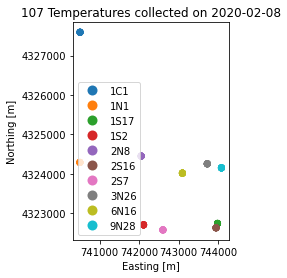

In [6]:
# Get the Matplotlib Axes object from the dataframe object, color the points by snow depth value
ax = df.plot(column='site_id', legend=True, cmap='tab10')

# Use non-scientific notation for x and y ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Set the various plots x/y labels and title.
ax.set_title(f'{len(df.index)} {dataset.title()}s collected on {collection_date.strftime("%Y-%m-%d")}')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]');


(I am converting from a geodataframe into a plain dataframe because when I tried plotting a groupby with a geodataframe it got confused with the 'geometry' column)

In [7]:
df_pd = pd.DataFrame(df)

In [8]:
# what are our columns
df_pd.columns

Index(['site_name', 'date', 'time_created', 'time_updated', 'id', 'doi',
       'date_accessed', 'instrument', 'type', 'units', 'surveyors', 'latitude',
       'longitude', 'northing', 'easting', 'elevation', 'utm_zone', 'geom',
       'time', 'depth', 'site_id', 'bottom_depth', 'comments', 'sample_a',
       'sample_b', 'sample_c', 'value'],
      dtype='object')

In [9]:
# make sure that our snow temperature values are a number
df_pd['value'] = df_pd.value.astype(float)
# and that site ids are strings
df_pd['site_id'] = df_pd.site_id.astype(str)

Decode the vegetation and snow depth classes into their own columns:

Vegetation classes

    1-3 = treeless (0% tree cover)

    4-6 = sparse (1-30% tree cover)

    7-9 = dense (31-100% tree cover)

Snow Depth classes

    1, 4, 7 = shallow (<90cm)

    2, 5, 8 = medium (90-122cm)

    3, 6, 9 = deep (>122cm)

Flight Lines

    ‘C’ = Crossline

    ‘N’ = North

    ‘S’ = South


In [10]:
# make dictionaries to map the site id "codes" to their meanings
vegetation_classes = {'0':'na', 'T':'na', 'G':'na', 'F':'na',
                      '1':'treeless', '2':'treeless', '3':'treeless', 
                      '4':'sparse', '5':'sparse', '6':'sparse', 
                      '7':'dense', '8':'dense', '9':'dense'}
snow_classes = {'0':'na', 'T':'na', 'G':'na', 'F':'na',
                '1':'shallow', '2':'medium', '3':'deep', 
                '4':'shallow', '5':'medium', '6':'deep', 
                '7':'shallow', '8':'medium', '9':'deep'}

# Grab the prefix of each site id and use the above dictionaries to look up the value according to the site id prefix (first number/letter of id)
df_pd['veg_class'] = [ vegetation_classes[id_string[0]] for id_string in df_pd['site_id']]
df_pd['snow_class'] = [ snow_classes[id_string[0]] for id_string in df_pd['site_id']]

Plot and group by snow class

(0.0, 120.0)

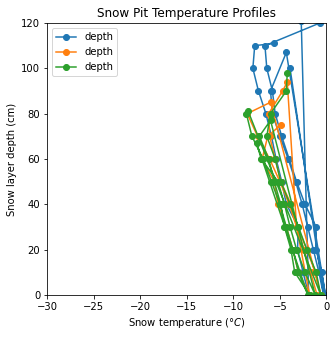

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

df_pd.groupby('snow_class').plot(x='value',y='depth', ax=ax, linestyle='-', marker='o');

ax.set_title('Snow Pit Temperature Profiles')
ax.set_xlabel('Snow temperature ($\degree C$)')
ax.set_xlim((-30,0))
ax.set_ylabel('Snow layer depth (cm)')
ax.set_ylim((0,120))

For each snow pit site, plot the temperature profile from this day

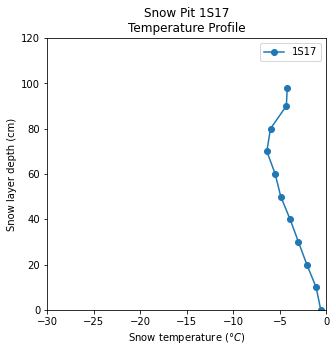

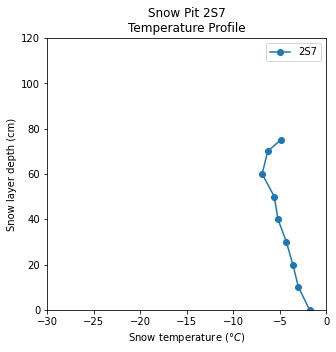

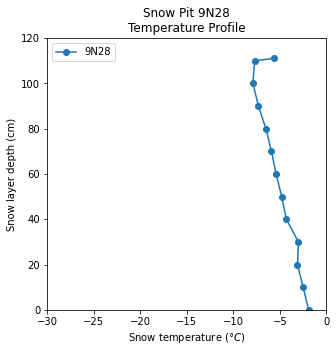

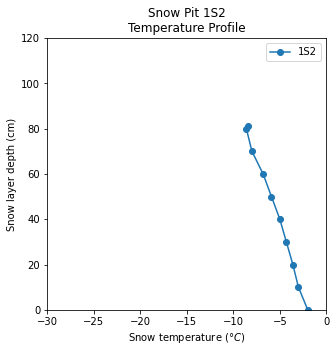

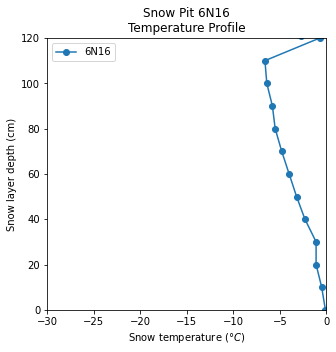

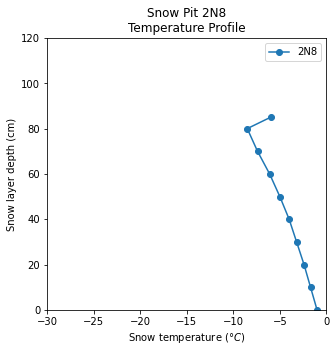

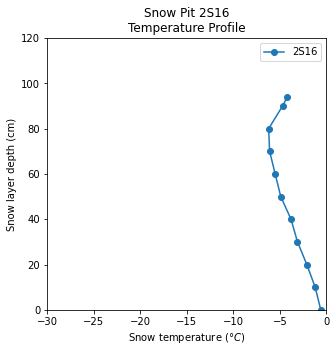

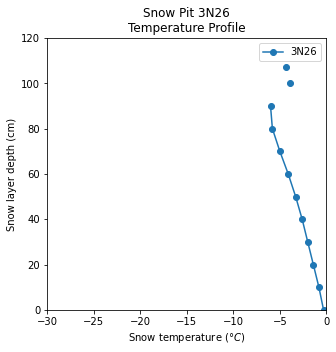

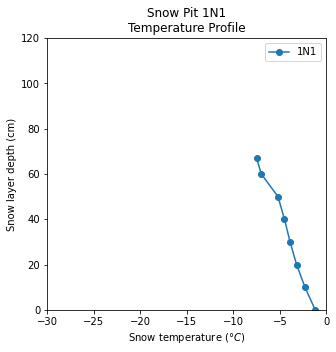

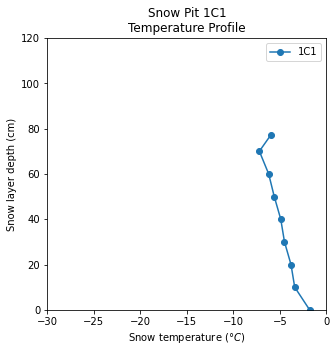

In [12]:
for i, this_site in enumerate(df_pd.site_id.unique()):
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    df_pd.where(df_pd.site_id == this_site).plot(x='value',y='depth', ax=ax, linestyle='-', marker='o', label=this_site);
    
    ax.set_title('Snow Pit {}\nTemperature Profile'.format(this_site))
    ax.set_xlabel('Snow temperature ($\degree C$)')
    ax.set_xlim((-30,0))
    ax.set_ylabel('Snow layer depth (cm)')
    ax.set_ylim((0,120))